# Adult Dataset – LGBM Baseline

## 目的

このノートブックでは、Adult Income データに対して LGBM モデルのベースラインを構築し、学習および交差検証（CV）評価によって分類性能を把握する。

さらに、特徴量重要度（feature importance）を確認することで、モデルが依存している変数構造を整理する。

また、Confusion Matrix および補助的可視化により、正例・負例の分布や誤分類の傾向を確認し、特徴量設計（FE）および判定閾値検討の基礎情報とする。

本分析は、後続の構造解析および改善検討の基準点を与えることを目的とする。

## 目次

1. データ読み込み・前処理
2. モデル設定・学習設定
3. CV評価/特徴量重要度
4. 予測・評価可視化（予測確率ヒストグラム、ROC Curve、Confusion Matrix）
5. 結果

## 1. データ読み込み／前処理

In [2]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# --- プロジェクトルート検出（最優先）---
ROOT = Path.cwd()
while not (ROOT / "data").exists():
    ROOT = ROOT.parent

sys.path.append(str(ROOT))

# --- src imports（必ず後）---
from src.lgbm import preprocess, train_model


# --- 再現性 ---
np.random.seed(42)

# --- データ ---
RAW_TRAIN = ROOT / "data/raw/adult.data"
X, y, feature_cols = preprocess(RAW_TRAIN)

# --- 型安定化 ---
y_np = y.to_numpy() if isinstance(y, pd.Series) else np.asarray(y)
y_np = y_np.astype(np.int32)


## 2. モデル設定/学習設定

本事例では、LightGBM を用い、
学習率・木構造・early stopping 等の条件は
train_model() にて定義された設定を用いる。

## 3. CV評価/特徴量重要度

交差検証（StratifiedKFold）を用いて、学習データ上で LGBM モデルの分類性能を定量的に評価する。
各 fold の AUC を計算し、平均値と標準偏差を確認することで、モデル全体の性能水準や安定性を把握する。
この段階では、補助的可視化は行わず、性能評価に必要な指標（CV AUC）のみを用いる

In [3]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

aucs = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y_np), 1):

    X_tr, y_tr = X.iloc[tr_idx], y_np[tr_idx]
    X_va, y_va = X.iloc[va_idx], y_np[va_idx]

    model = train_model(X_tr, y_tr, X_va, y_va)
    p_va = model.predict_proba(X_va)[:, 1]

    auc = roc_auc_score(y_va, p_va)
    aucs.append(auc)

    print(f"fold {fold}: AUC = {auc:.6f}")

print("-" * 40)
print(f"CV AUC mean = {np.mean(aucs):.6f}")
print(f"std         = {np.std(aucs):.6f}")


Early stopping, best iteration is:
[391]	valid_0's auc: 0.923734	valid_0's binary_logloss: 0.287251
fold 5: AUC = 0.923734
----------------------------------------
CV AUC mean = 0.922214
std         = 0.001467


CV AUC の平均値は 0.922、標準偏差は 0.0015 であり、モデルの性能が高く安定していることが確認できた。

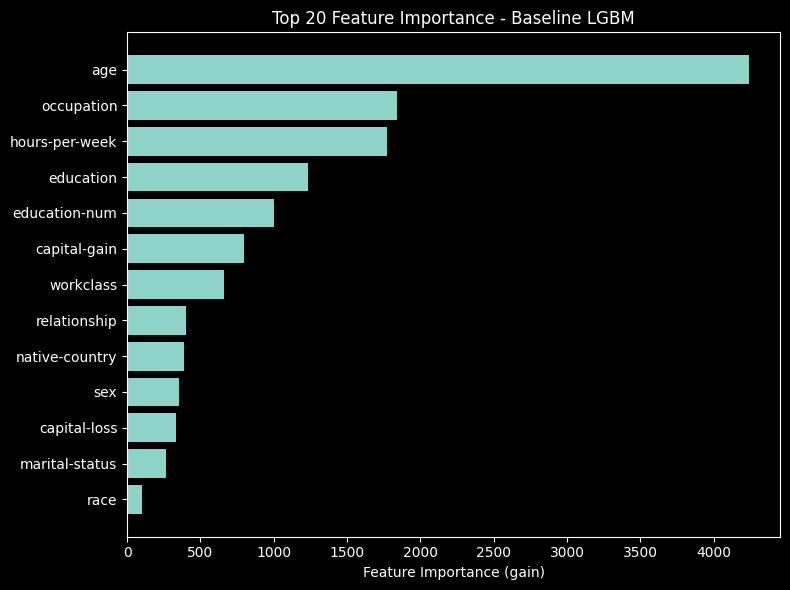

In [4]:
# --- データ分割 ---
X_tr, X_va, y_tr, y_va = train_test_split(X, y_np, test_size=0.2, random_state=42, stratify=y_np)

# --- モデル学習 ---
model = train_model(X_tr, y_tr, X_va, y_va)  # train_modelは引数4つ

# --- Feature Importance ---
fi_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": model.feature_importances_  # デフォルトはgain
}).sort_values("importance", ascending=False).reset_index(drop=True)

print(fi_df.head(20))  # 上位20特徴量確認

# --- 可視化（任意） ---
plt.figure(figsize=(8,6))
plt.barh(fi_df["feature"].head(20)[::-1], fi_df["importance"].head(20)[::-1])
plt.xlabel("Feature Importance (gain)")
plt.title("Top 20 Feature Importance - Baseline LGBM")
plt.tight_layout()
plt.show()


本図は、LGBM ベースラインモデルにおける gain ベースの特徴量重要度（上位20）を示している。

最も高い重要度を示したのは age であり、他の変数と比較して支配的な寄与を持つ。これは、収入区分（>50K / ≤50K）の分離において年齢が強い識別力を持つことを示唆する。

次いで occupation, hours-per-week, education, education-num が続く。
これらは職業属性・労働投入量・教育水準という、人間資本・就業構造に直接関係する変数群であり、目的変数との整合的な関係が確認できる。

capital-gain / capital-loss は中位に位置している。
理論的には高収入と関連が想定されるが、該当値がスパースかつ偏在しているため、モデル全体への平均的寄与は限定的と解釈できる。

一方、race, marital-status, sex, native-country は相対的に低い重要度となった。
これらは単独では分離力が弱く、主要な説明変数（年齢・労働・教育系）を補助する役割に留まっている。

全体として、

- 年齢（ライフサイクル要因）
- 労働時間（投入量要因）
- 教育（人的資本要因）
- 職業（就業構造要因）

がベースラインモデルの予測を主導している構造が確認された。

本結果は、
後続の PCA / LS 構造解析における「どの変数群が支配的か」の事前把握として機能する。

## 4. 予測・評価可視化（予測確率ヒストグラム、ROC Curve、Confusion Matrix）

代表的な LGBM モデルを構築し、各サンプルの予測確率を算出した上で、ヒストグラム、ROC Curve、Confusion Matrix、および NUM_COLS の特徴量に対する正誤色分け散布図を作成する。

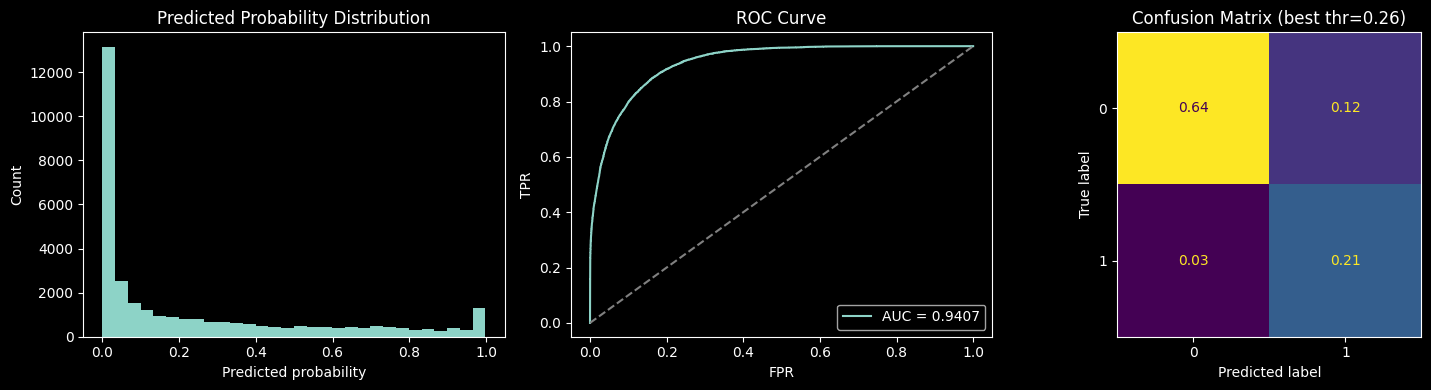

In [7]:
del auc
from sklearn.metrics import auc

# ==========================
# モデル学習
# ==========================
X_train_lgb, X_valid_lgb, y_train_lgb, y_valid_lgb = train_test_split(
    X, y_np, test_size=0.2, random_state=42, stratify=y_np
)
model = train_model(X_train_lgb, y_train_lgb, X_valid_lgb, y_valid_lgb)

# ==========================
# 予測確率と正解ラベル
# ==========================
p = model.predict_proba(X)[:, 1]
y_true = y_np

# ==========================
# ROC計算
# ==========================
fpr, tpr, thresholds = roc_curve(y_true, p)
roc_auc = auc(fpr, tpr)

# ==========================
# 最適閾値（左上に最も近い点）
# ==========================
dist = ((fpr**2) + (1 - tpr)**2)**0.5
best_idx = dist.argmin()
best_thr = thresholds[best_idx]

# ==========================
# Confusion Matrix
# ==========================
y_pred = (p >= best_thr).astype(int)
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm / cm.sum()  # 全体で1に正規化

# ==========================
# 1セル3図
# ==========================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1) 予測確率ヒストグラム
axes[0].hist(p, bins=30)
axes[0].set_title("Predicted Probability Distribution")
axes[0].set_xlabel("Predicted probability")
axes[0].set_ylabel("Count")

# 2) ROC Curve
axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
axes[1].plot([0, 1], [0, 1], linestyle="--", color='gray')
axes[1].set_title("ROC Curve")
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].legend()

# 3) Confusion Matrix（正規化）
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[0,1])
disp.plot(ax=axes[2], values_format=".2f", colorbar=False)
axes[2].set_title(f"Confusion Matrix (best thr={best_thr:.2f})")

plt.tight_layout()
plt.show()


予測確率のヒストグラムを見ると、大多数のサンプルは低確率側に集中しており、正例は少数派であることが確認できる。

ROC Curve による分類能力は AUC ≈ 0.941 で、モデルは全体として高い識別性能を持っている。

Confusion Matrix（閾値 0.26）を見ると、全体の約85% が正しく分類され、誤分類は少数に留まることがわかる。

これらの可視化は、モデルが学習データ上でどのような予測挙動を示しているかを直感的に把握する補助的な手段となる。

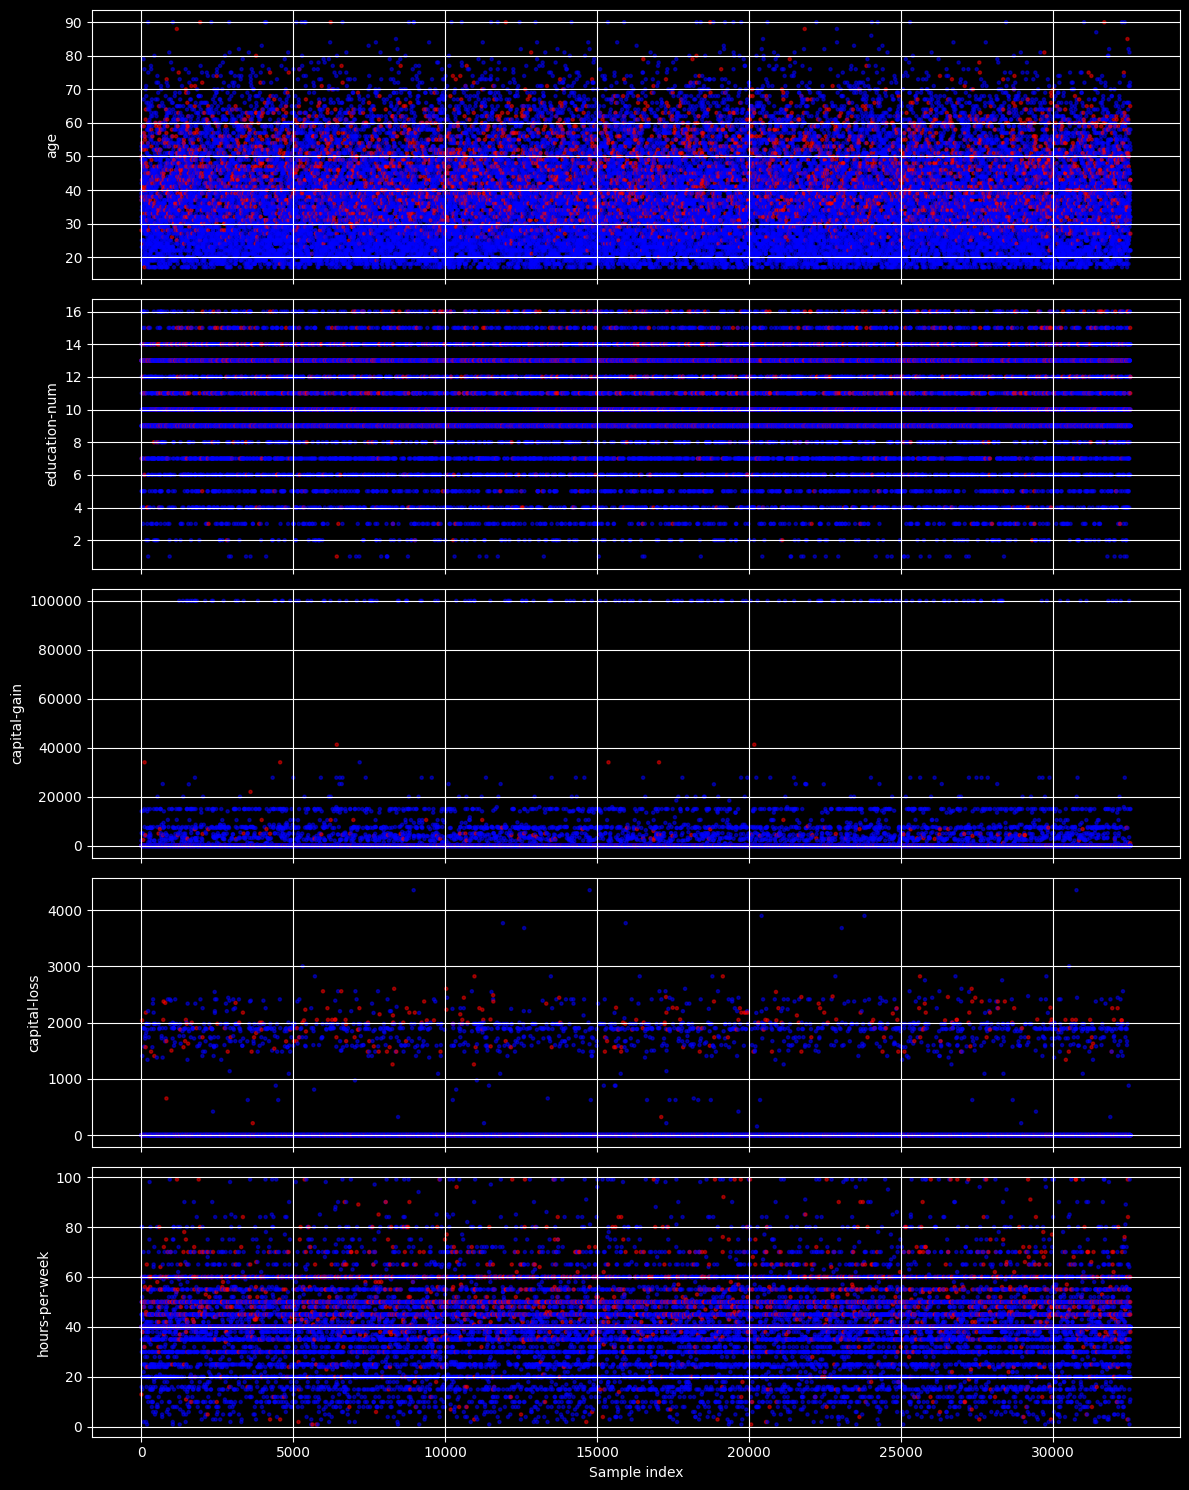

In [6]:
# ==========================
# 予測ラベルと正誤判定
# ==========================
threshold = 0.26  # ROCで最適と判定された閾値
y_pred = (model.predict_proba(X)[:,1] >= threshold).astype(int)

# 正誤フラグ
correct = (y_pred == y_np).astype(int)

# NUM_COLSの特徴量をDataFrame化
NUM_COLS = ["age","education-num","capital-gain","capital-loss","hours-per-week"]
X_num = X[NUM_COLS] if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=NUM_COLS)

# ==========================
# インデックス散布図
# ==========================
fig, axes = plt.subplots(len(NUM_COLS), 1, figsize=(12, 3*len(NUM_COLS)), sharex=True)

for i, col in enumerate(NUM_COLS):
    axes[i].scatter(
        X_num.index,       # サンプルインデックス
        X_num[col],        # 特徴量値
        c=correct,         # 正誤で色分け
        cmap='bwr_r',      # 青=正解, 赤=誤分類
        s=5,               # 点サイズ
        alpha=0.5          # 重なり調整
    )
    axes[i].set_ylabel(col)
    axes[i].grid(True)

axes[-1].set_xlabel("Sample index")
plt.tight_layout()
plt.show()


NUM_COLS の各特徴量に対して、正しく分類されたサンプルは青、誤分類サンプルは赤で色分けしたインデックス散布図を見ると、全体として青が多数を占め、赤は散在していることが確認できる。

個別の特徴量ごとに見ると以下の傾向がある：

- age：幅広く散らばっており、誤分類は特定年齢に集中せず、全体にまんべんなく分布
- education-num：青が多数を占め、赤は低〜中間値に少数散在
- capital-gain：ほとんどのサンプルは0付近に集中しており、低〜中間値に誤分類が散見される
- capital-loss：誤分類は、特定の値域に偏らず散在
- hours-per-week：広範囲に青が分布し、赤は散在するが特に、40以上で多く見られる。

これらから、モデルの予測精度は高く、誤分類は各特徴量の特定値だけでは説明できず、複合的な要因によることが示唆される。

## 5. 結果

LGBMベースラインモデルの評価・可視化結果は以下の通りである。

1. CV評価

交差検証（StratifiedKFold）による平均AUCは 0.922、標準偏差は 0.0015 で、モデルは高い性能と安定性を示した。

2. 代表モデルによる補助可視化
    - 予測確率ヒストグラムでは、大多数のサンプルが低確率側に偏り、正例は少数派であることが確認された。
    - ROC Curve による分類能力は AUC ≈ 0.941 で、代表モデルは全体的に高い識別性能を持つことが示された。
    - Confusion Matrix（閾値 0.26）では、全体の約 85% が正しく分類され、誤分類は少数に留まることが確認できた。
    - NUM_COLS のインデックス散布図では、正しく分類されたサンプルは青、誤分類は赤で示され、特徴量別に以下の傾向が見られた：
        - age：誤分類は特定年齢に集中せず、全体に散在
        - education-num：誤分類は低〜中間値に少数散在
        - capital-gain：誤分類は低〜中間値に散見される
        -  capital-loss：誤分類は少数で散在
        - hours-per-week：誤分類は散在し、突出値にはほとんど見られない

これらの結果から、モデルの分類性能は全体的に高く、誤分類は各特徴量の単独値だけでは説明できず、複合的な要因によって生じていることが示唆される。また、CV評価と代表モデル可視化を組み合わせることで、全体性能の把握と誤分類パターンの理解を統合的に評価できる構造となっている。